In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets.samples_generator import make_blobs

%matplotlib inline

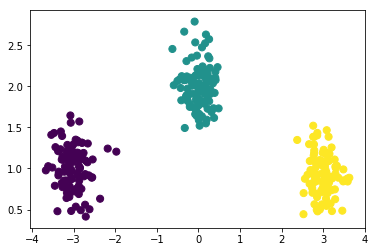

In [3]:
# Create the  training data
np.random.seed(2)
X, y = make_blobs(n_samples=300,cluster_std=.25, centers=np.array([(-3,1),(0,2),(3,1)]))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50)

In [3]:
from sklearn.base import BaseEstimator, ClassifierMixin, clone

class OneVsAllClassifier(BaseEstimator, ClassifierMixin):  
    """One-vs-all classifier
    We assume that the classes will be the integers 0,..,(num_classes-1)
    We assume that the estimator provided to the class, after fitting, has a "decision_function" that 
    returns the score for the positive class
    """
    def __init__(self, estimator, n_classes):      
        """Constructed with the number of classes and an estimator (e.g. an
        SVM estimator from sklearn)"""
        self.n_classes = n_classes 
        self.estimators = [clone(estimator) for _ in range(n_classes)]
        self.fitted = False

    def fit(self, X, y=None):
        """
        This should fit one classifier for each class.
        self.estimators_[i] should be fit on class i vs rest
        """
        # Create the new training data
        for the_class in range(self.n_classes):
            # ova stands for one-vs-all
            y_ova = np.zeros(y.shape[0])
            y_ova[y == the_class] = 1
            self.estimators[the_class].fit(X, y_ova)
            
        self.fitted = True  
        return self   

    def decision_function(self, X):
        """Returns the score of each input for each class. Assumes
        that the given estimator also implements the decision_function method (which sklearn SVMs do), 
        and that fit has been called.
        @param X : array-like, shape = [n_samples, n_features]
        @return array-like, shape = [n_samples, n_classes]
        """
        if not self.fitted:
            raise RuntimeError("You must train classifer before predicting data.")

        if not hasattr(self.estimators[0], "decision_function"):
            raise AttributeError(
                "Base estimator doesn't have a decision_function attribute.")

        return np.array([est.decision_function(X) for est in self.estimators]).T
    
    def predict(self, X):
        """Predict the class with the highest score."""
        return np.argmax(self.decision_function(X), axis=1)

 

Coeffs 0
[[-1.05852747 -0.90296521]]
Coeffs 1
[[0.34763875 0.3699639 ]]
Coeffs 2
[[ 0.89162796 -0.82467394]]


array([[100,   0,   0],
       [  0, 100,   0],
       [  0,   9,  91]])

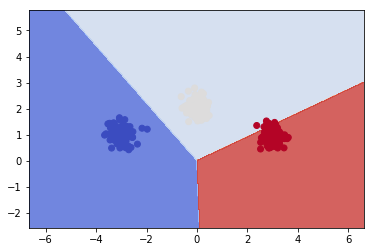

In [4]:
from sklearn import svm
svm_estimator = svm.LinearSVC(loss='hinge', fit_intercept=False, C=2)
clf_onevsall = OneVsAllClassifier(svm_estimator, n_classes=3)
clf_onevsall.fit(X,y)

for i in range(3) :
    print("Coeffs %d"%i)
    print(clf_onevsall.estimators[i].coef_) #Will fail if you haven't implemented fit yet
    
# create a mesh to plot in
h = .02  # step size in the mesh
x_min, x_max = min(X[:,0])-3,max(X[:,0])+3
y_min, y_max = min(X[:,1])-3,max(X[:,1])+3
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
mesh_input = np.c_[xx.ravel(), yy.ravel()]

Z = clf_onevsall.predict(mesh_input)
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)


from sklearn import metrics
metrics.confusion_matrix(y, clf_onevsall.predict(X))

In [11]:
def zeroOne(y,a) :
    '''
    Computes the zero-one loss.
    @param y: output class
    @param a: predicted class
    @return 1 if different, 0 if same
    '''
    return int(y != a)

def featureMap(X,y,num_classes) :
    '''
    Computes the class-sensitive features.
    @param X: array-like, shape = [n_samples,n_inFeatures], input features for input data
    @param y: int, a target class
    @return array-like, shape = [n_samples,n_outFeatures], the class sensitive features for class y
    '''
    num_samples, num_inFeatures = (1,X.shape[0]) if len(X.shape) == 1 else (X.shape[0],X.shape[1])
    m = np.zeros((num_samples, num_inFeatures*num_classes))
    m[:,y*num_inFeatures:(y+1)*num_inFeatures] = X
    return m

def sgd(X, y, num_outFeatures, subgd, eta = 0.1, T = 10000):
    '''
    @param X: array-like, shape = [n_samples,n_features], input training data 
    @param y: array-like, shape = [n_samples,], class labels
    @param num_outFeatures: number of class-sensitive features
    @param subgd: function taking x,y and giving subgradient of objective
    @param eta: learning rate for SGD
    @param T: maximum number of iterations
    @return: vector of weights
    '''
    num_samples = X.shape[0]
    w = np.zeros((T, num_outFeatures))
    np.random.seed(123)
    for t in range(T-1):
        ind = np.random.randint(num_samples)
        v = subgd(X[ind],y[ind],w[t])
        w[t+1] = w[t] - eta * v
    return w[T-1]

class MulticlassSVM(BaseEstimator, ClassifierMixin):
    def __init__(self, num_outFeatures, lam=1.0, num_classes=3, Delta=zeroOne, Psi=featureMap):       
        '''
        Creates a MulticlassSVM estimator
        @param num_outFeatures: number of class-sensitive features produced by Psi
        @param lam: l2 regularization parameter
        @param num_classes: number of classes (assumed numbered 0,..,num_classes-1)
        @param Delta: class-sensitive loss function taking two arguments (i.e., target margin)
        @param Psi: class-sensitive feature map taking two arguments
        '''
        self.lam = lam
        self.num_classes = num_classes
        self.Delta = Delta
        self.Psi = lambda X,y : Psi(X,y,num_classes)
        self.num_outFeatures = num_outFeatures
        self.fitted = False
    
    def subgradient(self,x,y,w):
        '''
        Computes the subgradient at a given data point x,y
        @param x: sample input
        @param y: sample class
        @param w: parameter vector
        @return returns subgradient vector at given x,y,w
        '''
        loss = [self.Delta(i, y)+np.dot(w, np.ravel(self.Psi(x, i) - self.Psi(x, y))) for i in range(self.num_classes)]
        y_hat = loss.index(max(loss))
        return np.ravel(self.Psi(x, y_hat)-self.Psi(x, y)) + 2*self.lam*w
    
    def fit(self,X,y,eta=0.1,T=10000):
        '''
        Fits multiclass SVM
        @param X: array-like, shape = [num_samples,num_inFeatures], input data
        @param y: array-like, shape = [num_samples,], input classes
        @param eta: learning rate for SGD
        @param T: maximum number of iterations
        @return returns self
        '''
        self.coef_ = sgd(X,y,self.num_outFeatures,self.subgradient,eta,T)
        self.fitted = True
        return self
    
    def decision_function(self, X):
        '''
        Returns the score of each input for each class. Assumes
        that fit has been called.
        @param X : array-like, shape = [n_samples, n_inFeatures]
        @return array-like, shape = [n_samples, n_classes]
        '''
        if not self.fitted:
            raise RuntimeError("You must train classifer before predicting data.")

        w = np.reshape(self.coef_,(-1,1))
        return np.array([np.ravel(np.dot(self.Psi(X,y),w)) for y in range(self.num_classes)]).T
    
    def predict(self, X):
        '''
        Predict the class with the highest score.
        @param X: array-like, shape = [n_samples, n_inFeatures], input data to predict
        @return array-like, shape = [n_samples,], class labels predicted for each data point
        '''
        return np.argmax(self.decision_function(X), axis=1)

w:
[-0.34438326 -0.05159277 -0.01039962  0.10210863  0.35478288 -0.05051586]


array([[100,   0,   0],
       [  0, 100,   0],
       [  0,   0, 100]])

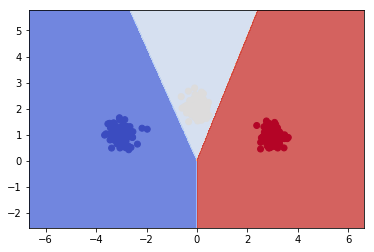

In [18]:
est = MulticlassSVM(6,lam=1)
est.fit(X,y,eta=0.001,T=70000)
print("w:")
print(est.coef_)
Z = est.predict(mesh_input)
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)


from sklearn import metrics
metrics.confusion_matrix(y, est.predict(X))